# Flower Recognition with EfficientNetB1
https://www.kaggle.com/alxmamaev/flowers-recognition/home


![](https://1.bp.blogspot.com/-Cdtb97FtgdA/XO3BHsB7oEI/AAAAAAAAEKE/bmtkonwgs8cmWyI5esVo8wJPnhPLQ5bGQCLcBGAs/s1600/image4.png)

![](https://1.bp.blogspot.com/-DjZT_TLYZok/XO3BYqpxCJI/AAAAAAAAEKM/BvV53klXaTUuQHCkOXZZGywRMdU9v9T_wCLcBGAs/s1600/image2.png)

In [1]:
# GPU usage information

!nvidia-smi

Tue Feb  1 15:02:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Setting Random Seed

In [2]:
from numpy.random import seed
seed(1)
import tensorflow as tf
tf.random.set_seed(2)

# Load Data

In [3]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1vYdIDWC5FSaFeslc8HWxWlD7MtBsAz28' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1vYdIDWC5FSaFeslc8HWxWlD7MtBsAz28" -O flowers_dataset.zip && rm -rf /tmp/cookies.txt
#!wget https://storage.googleapis.com/dm-shared/flowers_dataset.zip -O flowers_dataset.zip && rm -rf /tmp/cookies.txt

--2022-02-01 15:02:08--  https://docs.google.com/uc?export=download&confirm=C5XK&id=1vYdIDWC5FSaFeslc8HWxWlD7MtBsAz28
Resolving docs.google.com (docs.google.com)... 74.125.132.101, 74.125.132.113, 74.125.132.138, ...
Connecting to docs.google.com (docs.google.com)|74.125.132.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-08-40-docs.googleusercontent.com/docs/securesc/rqm5e6gfc70i4bns4u39597nku30pfr2/c3eqcng9nu7fga0opmu4a4og8vmtpbpd/1643727675000/02633866375358958520/05578186731323176654Z/1vYdIDWC5FSaFeslc8HWxWlD7MtBsAz28?e=download [following]
--2022-02-01 15:02:08--  https://doc-08-40-docs.googleusercontent.com/docs/securesc/rqm5e6gfc70i4bns4u39597nku30pfr2/c3eqcng9nu7fga0opmu4a4og8vmtpbpd/1643727675000/02633866375358958520/05578186731323176654Z/1vYdIDWC5FSaFeslc8HWxWlD7MtBsAz28?e=download
Resolving doc-08-40-docs.googleusercontent.com (doc-08-40-docs.googleusercontent.com)... 172.217.214.132, 2607:f8b0:4001:c05::84
Connectin

In [4]:
 !unzip /content/flowers_dataset.zip &> /dev/null

#Import Necessary Library

In [5]:
import os
import random
import itertools
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as pyplot
import numpy as np
import pandas as pd

from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report

In [6]:
tf.__version__

'2.7.0'

# Data Preprocessing

In [7]:
train_dir = "/content/flowers_dataset/train"
val_dir = "/content/flowers_dataset/validate"
test_dir = "/content/flowers_dataset/test"

In [8]:
image_size = 240
num_class = 5

batch_size = 24

#image augmentation
train_datagen = ImageDataGenerator(
        rescale=1.0/255.0, 
        shear_range = 0.2,
        zoom_range = 0.2,
        fill_mode="nearest",
        vertical_flip=True,
        horizontal_flip=True)
 
validation_datagen = ImageDataGenerator(rescale=1.0/255.0)

#create train and validation 
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        val_dir,
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode='categorical')

Found 3025 images belonging to 5 classes.
Found 649 images belonging to 5 classes.


# Data Visualization

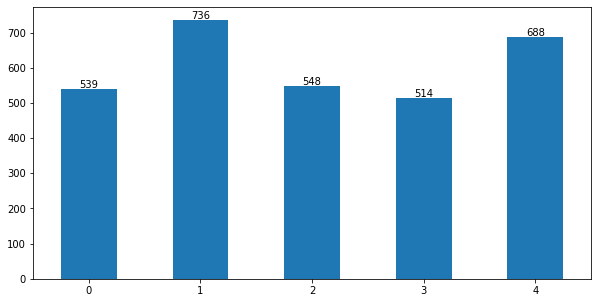

In [9]:
#train statistics
y_train = train_generator.labels
df_train = pd.DataFrame(y_train, columns=['class'])
ax = df_train['class'].value_counts().sort_index(na_position='first').plot(kind='bar', rot=0, figsize=(10,5), sort_columns=True)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2, height+4, '{:1.0f}'.format(height), ha="center")

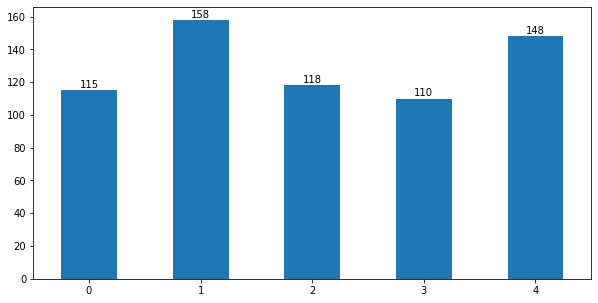

In [10]:
#validation statistics
y_val = validation_generator.labels
df_val = pd.DataFrame(y_val, columns=['class'])
ax = df_val['class'].value_counts().sort_index(na_position='first').plot(kind='bar', rot=0, figsize=(10,5), sort_columns=True)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2, height+1.5, '{:1.0f}'.format(height), ha="center")

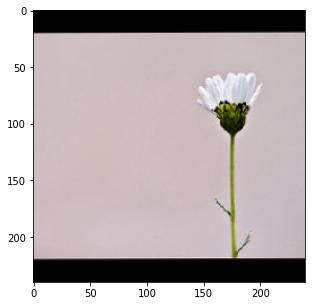

In [11]:
#visualize image from train set

x, y = train_generator.next() # x=image, y=label
i = random.randint(0, batch_size-1)
pyplot.subplots(1, 1, figsize=(10,5))
pyplot.imshow(x[i])

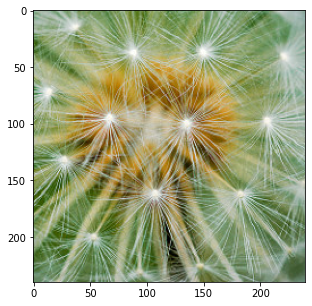

In [12]:
#visualize image from validation set

x, y = validation_generator.next()
i = random.randint(0, batch_size-1)
pyplot.subplots(1, 1, figsize=(10,5))
pyplot.imshow(x[i])

# Create Model

In [13]:
# list of models
# https://www.tensorflow.org/api_docs/python/tf/keras/applications/

from tensorflow.keras.applications import EfficientNetB1

efnb1 = EfficientNetB1(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

for layer in efnb1.layers:
  layer.trainable = True

model = Sequential()
model.add(efnb1)
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

27033600/27018416 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb1 (Functional)  (None, 8, 8, 1280)       6575239   
                                                                 
 flatten (Flatten)           (None, 81920)             0         
                                                                 
 dropout (Dropout)           (None, 81920)             0         
                                                                 
 dense (Dense)               (None, 256)               20971776  
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                         

# Train Model

In [14]:
# callbacks = [
#                ModelCheckpoint('efn1_best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1),
#                ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=3, verbose=1),
#                EarlyStopping(monitor='val_accuracy', patience=10, mode='max', verbose=1)
#                ]

# history = model.fit(
#     train_generator,
#     steps_per_epoch=len(train_generator),
#     epochs=100,
#     callbacks = callbacks,
#     validation_data = validation_generator,
#     validation_steps=len(validation_generator)
# )

#Plot Train and Validation Graphs

In [15]:
# #plot loss
# pyplot.figure(figsize=(30,5))
# pyplot.subplot(121)
# pyplot.plot(history.history['loss'])
# pyplot.plot(history.history['val_loss'])
# pyplot.title('Cross Entropy Loss')
# pyplot.ylabel('loss')
# pyplot.xlabel('epoch')
# pyplot.legend(['Train', 'Validate'], loc='upper left')

# #plot accuracy
# pyplot.subplot(122)
# pyplot.plot(history.history['accuracy'])
# pyplot.plot(history.history['val_accuracy'])
# pyplot.title('Classification Accuracy')
# pyplot.ylabel('accuracy')
# pyplot.xlabel('epoch')
# pyplot.legend(['Train', 'Validate'], loc='upper left')
# pyplot.show()

# Test Set Evaluation

In [16]:
# download pre-trained weight
!wget https://storage.googleapis.com/dm-shared/efn1_best_model.h5

--2022-02-01 15:02:35--  https://storage.googleapis.com/kao-weights/efn1_best_model.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.194.128, 142.250.152.128, 173.194.196.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 331367560 (316M) [application/octet-stream]
Saving to: ‘efn1_best_model.h5’

efn1_best_model.h5  100%[===================>] 316.02M   115MB/s    in 2.7s    

2022-02-01 15:02:38 (115 MB/s) - ‘efn1_best_model.h5’ saved [331367560/331367560]



In [17]:
#implement model
model.load_weights('efn1_best_model.h5')

In [18]:
#create test set
test_generator = validation_datagen.flow_from_directory(
        test_dir,
        target_size=(image_size, image_size),
        batch_size=1,
        class_mode='categorical')

Found 649 images belonging to 5 classes.


In [19]:
#evaluate test set
score = model.evaluate(test_generator, verbose=1)

print('Test loss: %.3f' % (score[0] * 100.0))
print('Test accuracy: %.3f' % (score[1] * 100.0))

649/649 [==============================] - 42s 36ms/step - loss: 0.2794 - accuracy: 0.9153
Test loss: 27.939
Test accuracy: 91.525


In [20]:
#split imagedatagenerator into x_test and y_test
from platform import python_version_tuple

if python_version_tuple()[0] == '3':
    xrange = range
    izip = zip
    imap = map
else:
    from itertools import izip, imap

x, y = izip(*(test_generator[i] for i in xrange(len(test_generator))))
x_test, y_test = np.vstack(x), np.vstack(y)

In [21]:
#predict values from test set
y_pred = model.predict(test_generator, steps = len(test_generator))
#convert predictions classes to one hot vectors
y_pred_classes = np.argmax(y_pred, axis=1)
#convert test observations to one hot vectors
y_true = np.argmax(y_test, axis=1)

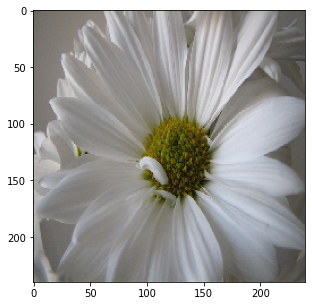

prediction is daisy
label is daisy


In [22]:
#visualize image from test set

i = random.randint(0, len(x_test))
pyplot.subplots(1, 1, figsize=(10,5))
pyplot.imshow(x_test[i])
pyplot.show()

#print target on test image.
idx_x = y_pred_classes[i]
idx_y = list(y_test[i]).index(1)
y_name = test_generator.class_indices
print('prediction is',list(y_name.keys())[list(y_name.values()).index(idx_x)]) 
print('label is',list(y_name.keys())[list(y_name.values()).index(idx_y)]) 

In [23]:
#plot confusion matrix
def plot_confusion_matrix(cm, classes, cmap=pyplot.cm.Blues):
  pyplot.imshow(cm, interpolation='nearest', cmap=cmap)
  pyplot.title('Confusion Matrix')
  pyplot.colorbar()
  tick_marks = np.arange(len(classes))
  pyplot.xticks(tick_marks, classes)
  pyplot.yticks(tick_marks, classes)

  thresh = cm.mean()
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    pyplot.text(j, i, cm[i, j],
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
    pyplot.tight_layout()
    pyplot.ylabel('True Label')
    pyplot.xlabel('Predicted Label')

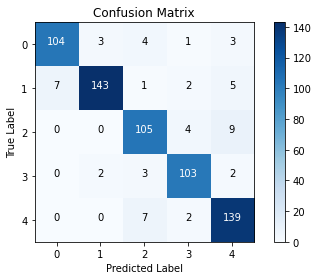

In [24]:
#compute confusion matrix 
confusion_mtx = confusion_matrix(y_true, y_pred_classes)
#plot confusion matrix
plot_confusion_matrix(confusion_mtx, classes=range(5))

In [25]:
#classification report
print(classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices, digits=4))

              precision    recall  f1-score   support

       daisy     0.9369    0.9043    0.9204       115
   dandelion     0.9662    0.9051    0.9346       158
        rose     0.8750    0.8898    0.8824       118
   sunflower     0.9196    0.9364    0.9279       110
       tulip     0.8797    0.9392    0.9085       148

    accuracy                         0.9153       649
   macro avg     0.9155    0.9150    0.9148       649
weighted avg     0.9168    0.9153    0.9155       649

